# SETUP

In [2]:
from google.colab import files
uploaded = files.upload()

Saving validation.csv to validation.csv


In [3]:
!pip install openai

!pip install llama_index

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.0/189.0 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.1 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfully uninstalled tenacity-9.0.0


In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import AutoModel, AutoTokenizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.metrics import accuracy_score

In [6]:
uploaded = files.upload()

Saving validation.jsonl to validation.jsonl


# DATA PROCESSING

In [19]:
dataset_name = "original_250"
nevir_df = pd.read_json(f"{dataset_name}.jsonl", lines=True)

In [20]:
nevir_df.head()

,id,WorkerId,q1,q2,doc1,doc2
0,444-2,0,What can usually cause an offender to get arre...,What cannot usually cause an offender to get a...,Drug possession is the crime of having one or ...,Drug possession is the crime of having one or ...
1,444-3,2,What offense hardly ever results in the crimin...,What offense always results in the criminal go...,Drug possession is the crime of having one or ...,Drug possession is the crime of having one or ...
2,445-2,6,Who did SSI invite to the X Games as an exhibi...,Who did SSI invite to the X Games as an exhibi...,Freeflying broke into the limelight in 1996 wh...,Freeflying broke into the limelight in 1996 wh...
3,445-3,2,Which team took part in the 1998 ESPN X Games ...,Which team took part in the 1998 ESPN X Games ...,Freeflying broke into the limelight in 1996 wh...,Freeflying broke into the limelight in 1996 wh...
4,446-2,2,Who did not agree with each other in terms of ...,Who agreed with each other in terms of attitud...,The population of the Thirteen States was not ...,The population of the Thirteen States was homo...


In [21]:
# Add new columns with the specified values
nevir_df['Expected_q1_q2'] = "High"
nevir_df['Expected_q1_doc1'] = "High"
nevir_df['Expected_q1_doc2'] = "Low"
nevir_df['Expected_q2_doc1'] = "Low"
nevir_df['Expected_q2_doc2'] = "High"

In [22]:
nevir_df.head()

,id,WorkerId,q1,q2,doc1,doc2,Expected_q1_q2,Expected_q1_doc1,Expected_q1_doc2,Expected_q2_doc1,Expected_q2_doc2
0,444-2,0,What can usually cause an offender to get arre...,What cannot usually cause an offender to get a...,Drug possession is the crime of having one or ...,Drug possession is the crime of having one or ...,High,High,Low,Low,High
1,444-3,2,What offense hardly ever results in the crimin...,What offense always results in the criminal go...,Drug possession is the crime of having one or ...,Drug possession is the crime of having one or ...,High,High,Low,Low,High
2,445-2,6,Who did SSI invite to the X Games as an exhibi...,Who did SSI invite to the X Games as an exhibi...,Freeflying broke into the limelight in 1996 wh...,Freeflying broke into the limelight in 1996 wh...,High,High,Low,Low,High
3,445-3,2,Which team took part in the 1998 ESPN X Games ...,Which team took part in the 1998 ESPN X Games ...,Freeflying broke into the limelight in 1996 wh...,Freeflying broke into the limelight in 1996 wh...,High,High,Low,Low,High
4,446-2,2,Who did not agree with each other in terms of ...,Who agreed with each other in terms of attitud...,The population of the Thirteen States was not ...,The population of the Thirteen States was homo...,High,High,Low,Low,High


In [23]:
dataset_name = "processed_nevir_250"

In [24]:
nevir_df.to_csv(f'{dataset_name}.csv')

In [12]:
files.download(f'{dataset_name}.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# EMBEDDING

## Embeding Setup

In [ ]:
# Load the NV-Embed-v2 model and tokenizer
model = AutoModel.from_pretrained("nvidia/NV-Embed-v2", trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained("nvidia/NV-Embed-v2", trust_remote_code=True)

In [15]:
# Method to generate embeddings
def get_embeddings(texts, batch_size=8, max_length=512):
    return model._do_encode(texts, batch_size=batch_size, max_length=max_length, num_workers=0, return_numpy=True)

## Embeddings Executed

In [16]:
q1_embeddings_name = f"embedding_of_queries_q1_from_dataset_{dataset_name}.csv"
q2_embeddings_name = f"embedding_of_queries_q2_from_dataset_{dataset_name}.csv"
doc1_embeddings_name = f"embedding_of_documents_doc1_from_dataset_{dataset_name}.csv"
doc2_embeddings_name = f"embedding_of_documents_doc2_from_dataset_{dataset_name}.csv"

In [ ]:
q1_embeddings = get_embeddings(nevir_df["q1"].tolist())
q1_embeddings_df = pd.DataFrame(q1_embeddings)
q1_embeddings_df.to_csv(q1_embeddings_name, index=False)

q2_embeddings = get_embeddings(nevir_df["q2"].tolist())
q2_embeddings_df = pd.DataFrame(q2_embeddings)
q2_embeddings_df.to_csv(q2_embeddings_name, index=False)

doc1_embeddings = get_embeddings(nevir_df["doc1"].tolist())
doc1_embeddings_df = pd.DataFrame(doc1_embeddings)
doc1_embeddings_df.to_csv(doc1_embeddings_name, index=False)

doc2_embeddings = get_embeddings(nevir_df["doc2"].tolist())
doc2_embeddings_df = pd.DataFrame(doc2_embeddings)
doc2_embeddings_df.to_csv(doc2_embeddings_name, index=False)

## Embeddings Loaded

In [25]:
uploaded_embeddings = files.upload()

Saving embedding_of_documents_doc1_from_dataset_validation.csv to embedding_of_documents_doc1_from_dataset_validation.csv


In [30]:
# q1_embeddings_df = pd.read_csv(q1_embeddings_name)
# q2_embeddings_df = pd.read_csv(q2_embeddings_name)
doc1_embeddings_df = pd.read_csv(doc1_embeddings_name)
# doc2_embeddings_df = pd.read_csv(doc2_embeddings_name)

In [31]:
doc1_embeddings_df.head()

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,0.017192,0.012756,-0.000225,-0.009706,-0.019880,-0.003364,0.012502,-0.005890,-0.008191,-0.015790,...,0.005662,0.023178,0.006876,0.004707,0.014570,-0.010062,0.036891,-0.002249,-0.034295,0.006367
1,0.017192,0.012756,-0.000225,-0.009706,-0.019880,-0.003364,0.012502,-0.005890,-0.008191,-0.015790,...,0.005662,0.023178,0.006876,0.004707,0.014570,-0.010062,0.036891,-0.002249,-0.034295,0.006367
2,0.009728,-0.014131,-0.006458,-0.012822,0.004908,-0.050714,0.014705,-0.009692,-0.022606,-0.008187,...,-0.017830,-0.012691,0.014991,0.020846,0.012205,-0.077668,-0.029171,-0.000145,-0.000303,-0.000558
3,0.009728,-0.014131,-0.006458,-0.012822,0.004908,-0.050714,0.014705,-0.009692,-0.022606,-0.008187,...,-0.017830,-0.012691,0.014991,0.020846,0.012205,-0.077669,-0.029171,-0.000145,-0.000303,-0.000558
4,0.013888,-0.001807,-0.003344,-0.023411,-0.005790,-0.008048,-0.001254,0.013039,-0.020812,0.003126,...,0.005601,0.014093,0.002490,-0.009545,0.031251,-0.057717,-0.000326,0.000599,-0.018481,-0.010262


# COSINE SIMILARITY EXPERIMENT

## Compute Cosine Similarity

In [ ]:
def get_embedding_df(df_name="q1"):
    if df_name == "q1":
        return q1_embeddings_df
    elif df_name == "q2":
        return q2_embeddings_df
    elif df_name == "doc1":
        return doc1_embeddings_df
    elif df_name == "doc2":
        return doc2_embeddings_df
    else:
        ValueError("Feature name not found")

In [ ]:
def cosine_similarity_verification(embeddings_df_1_name="q1", embeddings_df_2_name="q2"):
    print("\n---------------------------------------------------------------------------------")
    print(f"Cosine similarity veryfying for: {embeddings_df_1_name} and {embeddings_df_2_name}")

    embeddings_df_1 = get_embedding_df(embeddings_df_1_name)
    embeddings_df_2 = get_embedding_df(embeddings_df_2_name)

    # Compute cosine similarity for corresponding pairs of rows
    cosine_similarities = [
        cosine_similarity([row1], [row2])[0][0]
        for row1, row2 in zip(embeddings_df_1.values, embeddings_df_2.values)
    ]

    # Convert the results to a DataFrame
    cosine_similarity_df = pd.DataFrame({
        "Pair Index": range(len(cosine_similarities)),
        "Cosine Similarity": cosine_similarities
    })

    # Add the original text columns 'q1' and 'q2' to the cosine similarity DataFrame
    cosine_similarity_df[embeddings_df_1_name] = nevir_df[embeddings_df_1_name]
    cosine_similarity_df[embeddings_df_2_name] = nevir_df[embeddings_df_2_name]

    cosine_similarity_df.to_csv(f'cosine_similarity_verification_for_{embeddings_df_1_name}_and_{embeddings_df_2_name}.csv', index=False)

    return cosine_similarity_df

In [ ]:
cosine_similarity_df_q1_q2 = cosine_similarity_verification("q1", "q2")
cosine_similarity_df_q1_doc1 = cosine_similarity_verification("q1", "doc1")
cosine_similarity_df_q1_doc2 = cosine_similarity_verification("q1", "doc2")
cosine_similarity_df_q2_doc1 = cosine_similarity_verification("q2", "doc1")
cosine_similarity_df_q2_doc2 = cosine_similarity_verification("q2", "doc2")


---------------------------------------------------------------------------------
Cosine similarity veryfying for: q1 and q2

---------------------------------------------------------------------------------
Cosine similarity veryfying for: q1 and doc1

---------------------------------------------------------------------------------
Cosine similarity veryfying for: q1 and doc2

---------------------------------------------------------------------------------
Cosine similarity veryfying for: q2 and doc1

---------------------------------------------------------------------------------
Cosine similarity veryfying for: q2 and doc2


In [ ]:
files.download(f'cosine_similarity_verification_for_q1_and_q2.csv')
files.download(f'cosine_similarity_verification_for_q1_and_doc1.csv')
files.download(f'cosine_similarity_verification_for_q1_and_doc2.csv')
files.download(f'cosine_similarity_verification_for_q2_and_doc1.csv')
files.download(f'cosine_similarity_verification_for_q2_and_doc2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
uploaded_cosine_similarity_verification = files.upload()

KeyboardInterrupt: 

In [16]:
# Load the cosine similarity results from the CSV files
cosine_similarity_df_q1_q2 = pd.read_csv('cosine_similarity_verification_for_q1_and_q2.csv')
cosine_similarity_df_q1_doc1 = pd.read_csv('cosine_similarity_verification_for_q1_and_doc1.csv')
cosine_similarity_df_q1_doc2 = pd.read_csv('cosine_similarity_verification_for_q1_and_doc2.csv')
cosine_similarity_df_q2_doc1 = pd.read_csv('cosine_similarity_verification_for_q2_and_doc1.csv')
cosine_similarity_df_q2_doc2 = pd.read_csv('cosine_similarity_verification_for_q2_and_doc2.csv')

In [24]:
def plot_density_distribution(similarities, colors, plot_name="Density Distribution of Cosine Similarities"):
    # Plot density distributions with custom colors
    plt.figure(figsize=(12, 8))
    for key, similarity_values in similarities.items():
        sns.kdeplot(
            similarity_values, label=key, fill=True, alpha=0.5, color=colors[key]
        )

    plt.title("Density Distribution of Cosine Similarities", fontsize=16)
    plt.xlabel("Cosine Similarity", fontsize=14)
    plt.ylabel("Density", fontsize=14)
    plt.legend(title="Embedding Pairs", fontsize=12)
    plt.grid(alpha=0.3)
    plt.show()

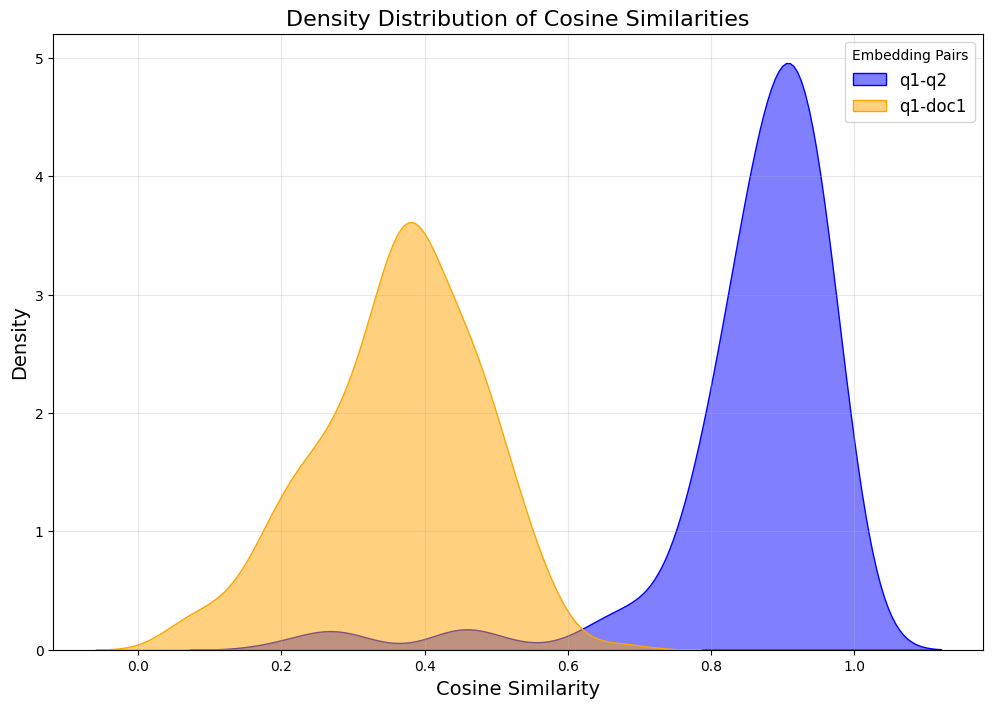

In [25]:
# Extract cosine similarity values for plotting
similarities = {
    "q1-q2": cosine_similarity_df_q1_q2["Cosine Similarity"],
    "q1-doc1": cosine_similarity_df_q1_doc1["Cosine Similarity"],
}

colors = {
    "q1-q2": "blue",
    "q1-doc1": "orange",
}

plot_density_distribution(similarities, colors, plot_name="Density Distribution of Cosine Similarities: Q1-Q2 & Q1-Doc1")

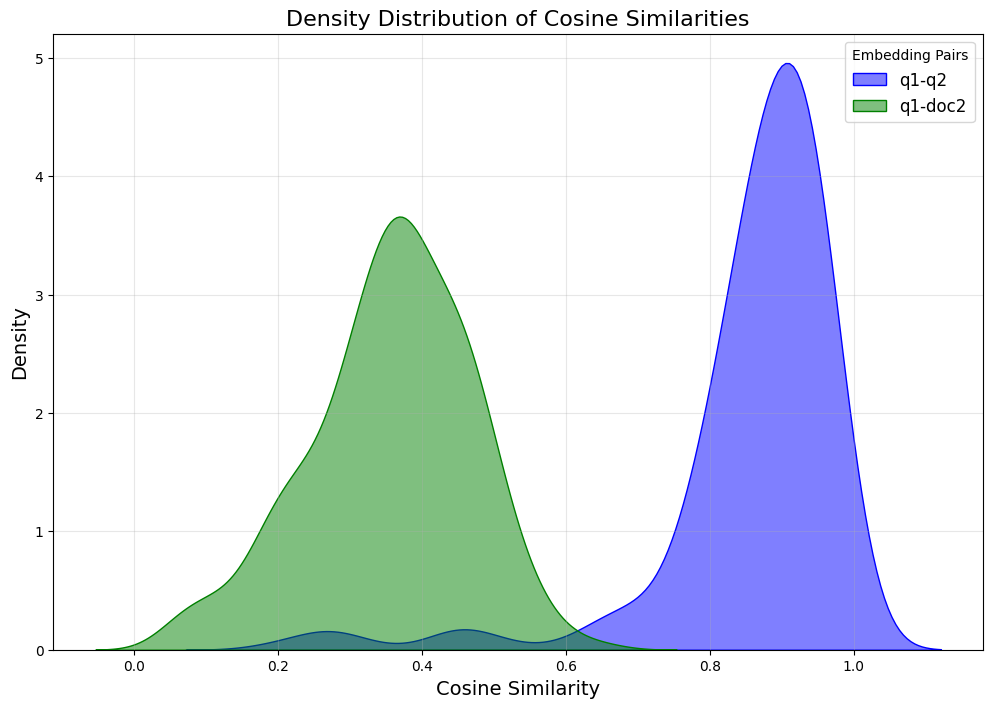

In [29]:
# Extract cosine similarity values for plotting
similarities = {
    "q1-q2": cosine_similarity_df_q1_q2["Cosine Similarity"],
    "q1-doc2": cosine_similarity_df_q1_doc2["Cosine Similarity"],
}

colors = {
    "q1-q2": "blue",
    "q1-doc2": "green",
}

plot_density_distribution(similarities, colors, plot_name="Density Distribution of Cosine Similarities: Q1-Q2 & Q1-Doc2")

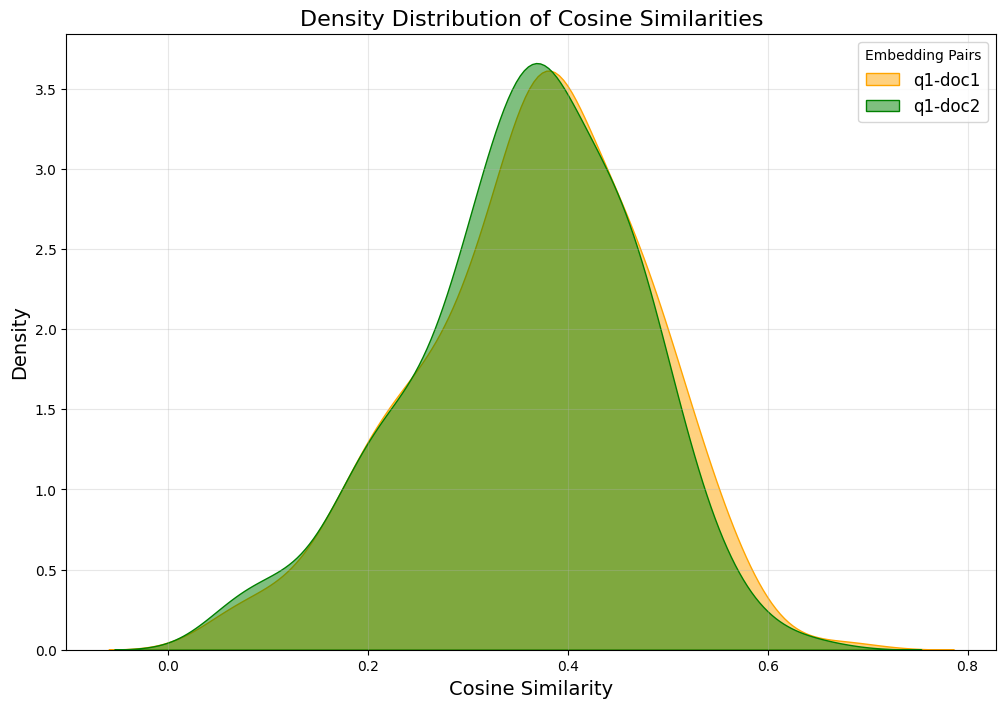

In [27]:
# Extract cosine similarity values for plotting
similarities = {
    "q1-doc1": cosine_similarity_df_q1_doc1["Cosine Similarity"],
    "q1-doc2": cosine_similarity_df_q1_doc2["Cosine Similarity"],
}

colors = {
    "q1-doc1": "orange",
    "q1-doc2": "green",
}

plot_density_distribution(similarities, colors, plot_name="Density Distribution of Cosine Similarities: Q1-Doc1 & Q1-Doc2")

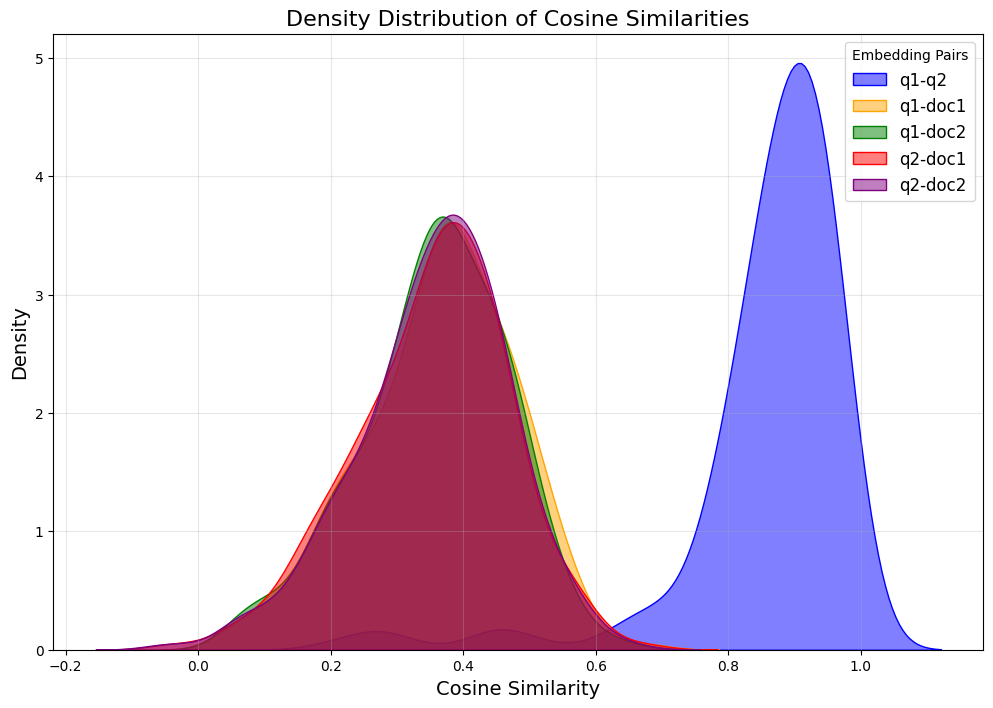

In [26]:
# Extract cosine similarity values for plotting
similarities = {
    "q1-q2": cosine_similarity_df_q1_q2["Cosine Similarity"],
    "q1-doc1": cosine_similarity_df_q1_doc1["Cosine Similarity"],
    "q1-doc2": cosine_similarity_df_q1_doc2["Cosine Similarity"],
    "q2-doc1": cosine_similarity_df_q2_doc1["Cosine Similarity"],
    "q2-doc2": cosine_similarity_df_q2_doc2["Cosine Similarity"],
}

# Define custom colors for each pair
colors = {
    "q1-q2": "blue",
    "q1-doc1": "orange",
    "q1-doc2": "green",
    "q2-doc1": "red",
    "q2-doc2": "purple",
}

plot_density_distribution(similarities, colors)